In [1]:
import numpy as np
import mccd.auxiliary_fun as mccd_aux
import mccd
from astropy.io import fits

import random

import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from sklearn.preprocessing import normalize
import itertools
import galsim

%pylab inline

Populating the interactive namespace from numpy and matplotlib


/Users/oa265351/opt/miniconda3/envs/denoising/lib/python3.9/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


## Defining the environment and visualization functions

For this notebook to work, you first need to fit MCCD models to your generated polynomial datasets 

In [2]:
def plot_imgs(mat, cmap = 'gist_stern', figsize=(20,20)):

    def dp(n, left): # returns tuple (cost, [factors])
        memo = {}   
        if (n, left) in memo: return memo[(n, left)]

        if left == 1:
            return (n, [n])

        i = 2
        best = n
        bestTuple = [n]
        while i * i <= n:
            if n % i == 0:
                rem = dp(n / i, left - 1)
                if rem[0] + i < best:
                    best = rem[0] + i
                    bestTuple = [i] + rem[1]
            i += 1

        memo[(n, left)] = (best, bestTuple)
        return memo[(n, left)]


    n_images = mat.shape[0]
    row_col = dp(n_images, 2)[1]
    row_n = int(row_col[0])
    col_n = int(row_col[1])

    figure(figsize=figsize)
    idx = 0

    for _i in range(row_n):
        for _j in range(col_n):

            plt.subplot(row_n,col_n,idx+1)
            plt.imshow(mat[idx,:,:], cmap=cmap);colorbar()
            plt.title('matrix id %d'%idx)

            idx += 1

    plt.show()

In [2]:

#base_dir = '/Users/tliaudat/Documents/PhD/MCCD_application/CFIS_app/tests/'

path_fitted_model = './fitted_mccd_model/fitted_model-2000001.npy'

#path_val_data = './../data/mccd_inputs/test_star_selection-2086592.fits'

# path_fitted_model = base_dir + 'test_n06/test_files/' + 'fitted_model-2099932.npy'
# path_val_data = base_dir + 'test_n06/test_files/' + 'validation_psf-2099932.fits'

fitted_model = np.load(path_fitted_model, allow_pickle=True)
print(fitted_model[0])
print(fitted_model[0].keys())
print(fitted_model[1].keys())


{'n_comp_loc': 14, 'd_comp_glob': 8, 'upfact': 1}
dict_keys(['n_comp_loc', 'd_comp_glob', 'upfact'])
dict_keys(['n_ccd', 'obs_pos', 'A_loc', 'A_glob', 'S', 'flux_ref', 'psf_size', 'VT', 'Pi', 'alpha', 'ccd_list'])


## Visualizing the eigenPSFs

In [4]:
A_loc = fitted_model[1]['A_loc']
A_glob = fitted_model[1]['A_glob']

S = fitted_model[1]['S']
S[-1].shape

(51, 51, 45)

In [5]:
S_glob = S[-1]

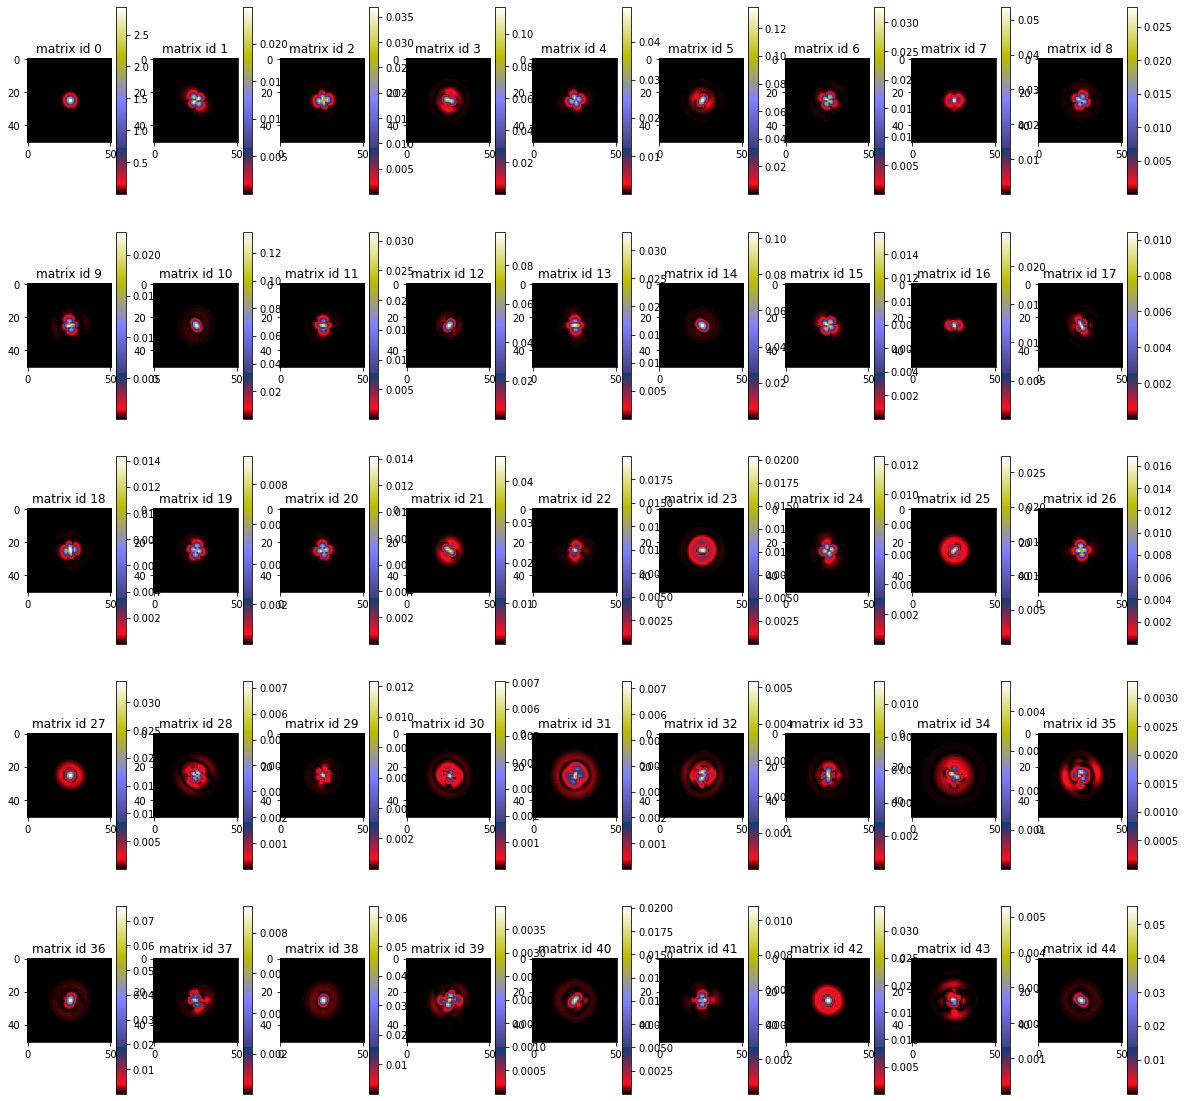

In [6]:
if S_glob.shape[2]>60:
    plot_imgs(mccd.utils.reg_format((abs(S_glob[:,:,:60]))), cmap = 'gist_stern', figsize=(20,20))
    plot_imgs(mccd.utils.reg_format((abs(S_glob[:,:,60:]))), cmap = 'gist_stern', figsize=(20,20))
else:
    plot_imgs(mccd.utils.reg_format(abs((S_glob))), cmap = 'gist_stern', figsize=(20,20))
    
    

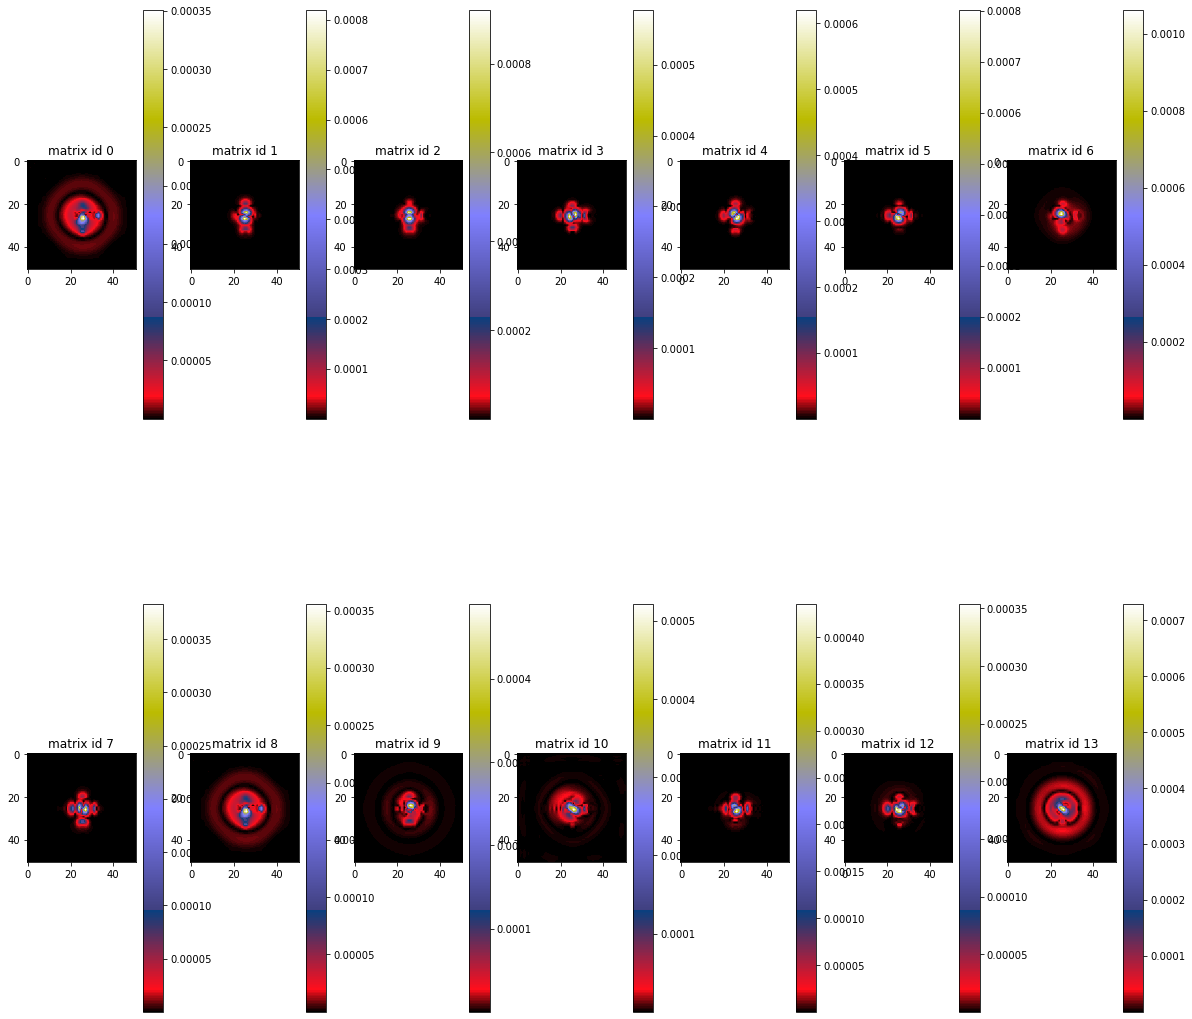

In [7]:
ccd_n = 32

S_loc = S[ccd_n]

plot_imgs(mccd.utils.reg_format(abs(S_loc)), cmap = 'gist_stern', figsize=(20,20))

## Get noiseless eigenPSFs from the fitted model

We retrieve the 45 global features plus the 14 local features times 40 CCD per model (20 models).
We end up with a 12100 eigenPSFs dataset composed with global and local features.

In [8]:
vignets_noiseless = np.zeros((1, 51, 51))

for j in range (20):
    
    path_fitted_model = './shapepipe_run_2021-06-15_11-16-47/mccd_fit_val_runner/output/fitted_model-200000'+str(j)+'.npy'
    fitted_model = np.load(path_fitted_model, allow_pickle=True)
    S = fitted_model[1]['S']

    for i in range (41):
        S_loc = S[i]
        vignets_noiseless = np.concatenate((vignets_noiseless, mccd.utils.reg_format(S_loc)), axis=0)
        
vignets_noiseless = np.delete(vignets_noiseless, 0, axis=0)
        
#for i in range (len(vignets_noiseless)):
#    vignets_noiseless[i] = vignets_noiseless[i]/np.linalg.norm(vignets_noiseless[i])
    

## Generate sim dataset

To enrich our dataset, we generate simulated stars with ellipticities and sizes within the range of real world data. With these, the model should try to learn more regular and global patterns of regular and ideally shaped stars.
We try to have a 60% eigenPSFS - 40% simulated stars composed model, so we add 8750 simulated stars to our 12100 eigenPSFs (42-58).

In [9]:
e1 = np.linspace(-0.12, 0.12, num=25, endpoint=True)
e2 = np.linspace(-0.12, 0.12, num=25, endpoint=True)
R2 = np.random.uniform(3, 8, 14)
sigma = np.sqrt(R2/2)
fwhm_psf = (2*np.sqrt(2*np.log(2)))*sigma
#SNR = np.linspace(10, 200, 10, dtype=int)
#SNR = np.append(SNR, 0)

# Generate the 1000 combinations of e1, e2 and fwhm

es = list(itertools.product(*[e1, e2, fwhm_psf]))
e1s = np.array([a for a,b,c in es])
e2s = np.array([b for a,b,c in es]) 
fwhms = np.array([c for a,b,c in es])

# Parameters
image_size = 51
psf_flux = 1.
beta_psf =  4.8 # 4.8# 2.5
pix_scale = 0.187
#desired_SNR = 30

# Generate the vignets
new_vignets_noiseless = np.zeros((e1s.shape[0],image_size,image_size))

for it in range(e1s.shape[0]):
    
    # PSF generation. Define size
    psf = galsim.Moffat(fwhm=fwhms[it]*pix_scale, beta=beta_psf)
#     psf = galsim.Gaussian(fwhm=fwhms[it]*pix_scale)#, beta=beta_psf)
    # Define the Flux
    psf = psf.withFlux(psf_flux)
    # Define the shear
    psf = psf.shear(g1=e1s[it], g2=e2s[it])
    # Draw the PSF on a vignet
    image_epsf = galsim.ImageF(image_size, image_size)
    # Define intrapixel shift (uniform distribution in [-0.5,0.5])
    rand_shift = np.random.rand(2)-0.5
    psf.drawImage(image=image_epsf, offset=rand_shift, scale=pix_scale)


    # Save images before adding the noise

    new_vignets_noiseless[it,:,:] = image_epsf.array
    
    

In [10]:
vignets_noiseless = np.concatenate((vignets_noiseless, new_vignets_noiseless), axis=0)
np.random.shuffle(vignets_noiseless)

## Add Gaussian noise to the dataset

We first generate a list of the SNRs we want to have in our dataset.
Then, we repeat this list to have a list of length our number of images composed of the different values of desired SNR, and we shuffle it. 
Then, we use this list to compute the sigma of the Gaussian distribution we want to attain such SNR according to the image we are applying the Gaussian filter to. We then generate len(dataset) Gaussian filters that we add to our dataset.

In [21]:
snr = np.linspace(0, 100, num=25)
snr = np.repeat(snr, 834)

In [22]:
image_size = 51
sigma_noise = np.zeros(len(vignets_noiseless))
np.random.shuffle(snr)
for i in range (len(vignets_noiseless)):
    if snr[i] > 0:
        sigma_noise[i] = np.sqrt((np.sum(vignets_noiseless[i]**2))/(snr[i] * image_size**2))
    else: 
        sigma_noise[i] = 0
        
gaussian_noise = np.zeros((len(vignets_noiseless), 51, 51))

for i in range (len(vignets_noiseless)):
    gaussian_noise[i] = np.random.normal(0, sigma_noise[i], (51, 51))

In [23]:
vignets_with_noise = vignets_noiseless + gaussian_noise

## Checking out some stars of our final dataset

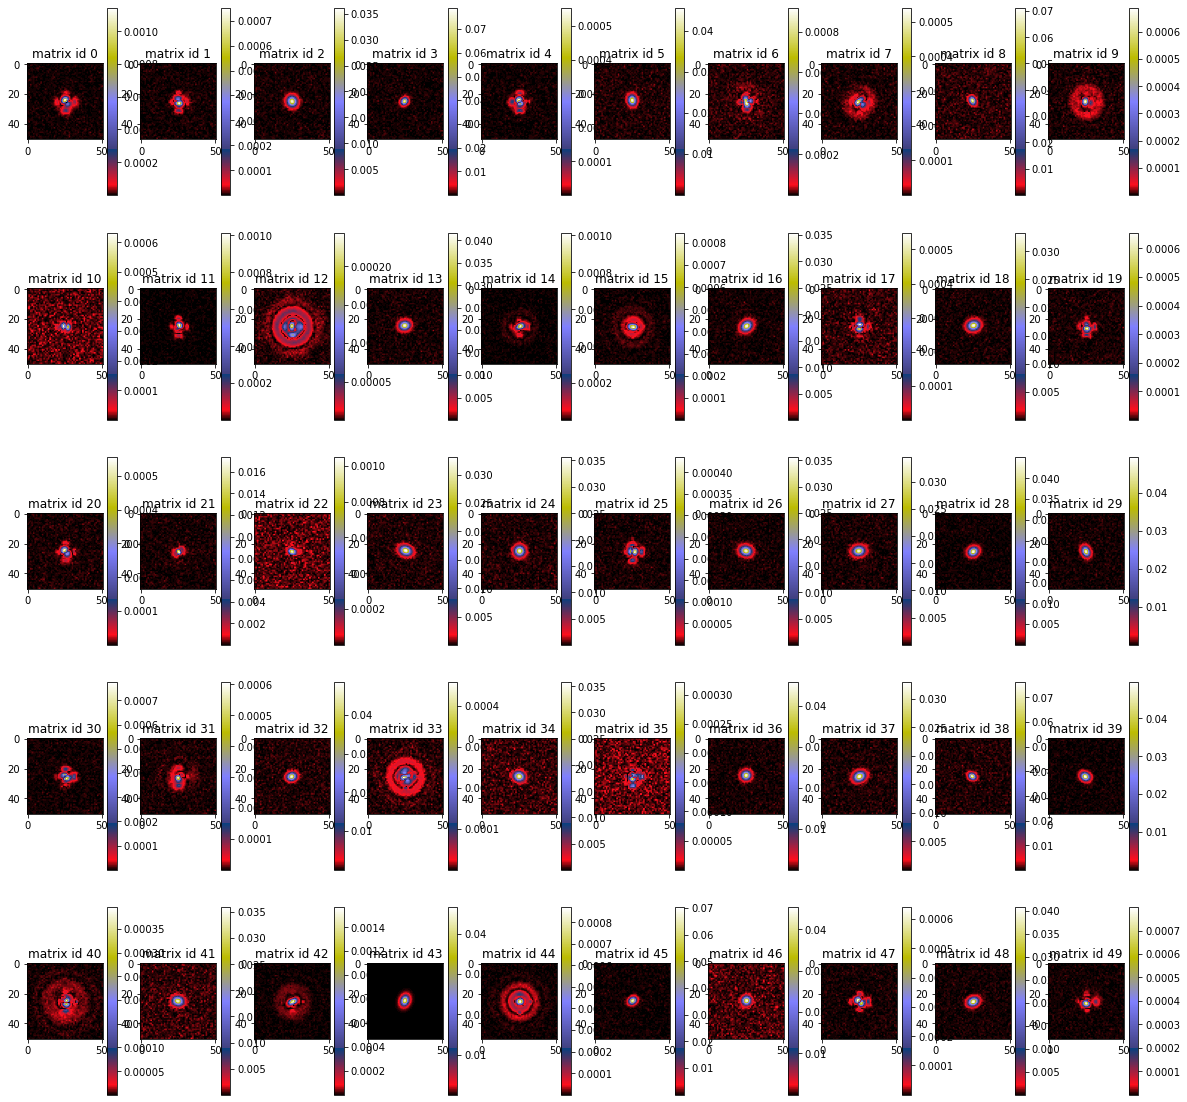

In [24]:
plot_imgs(abs(vignets_with_noise[3400:3450, :, :]))

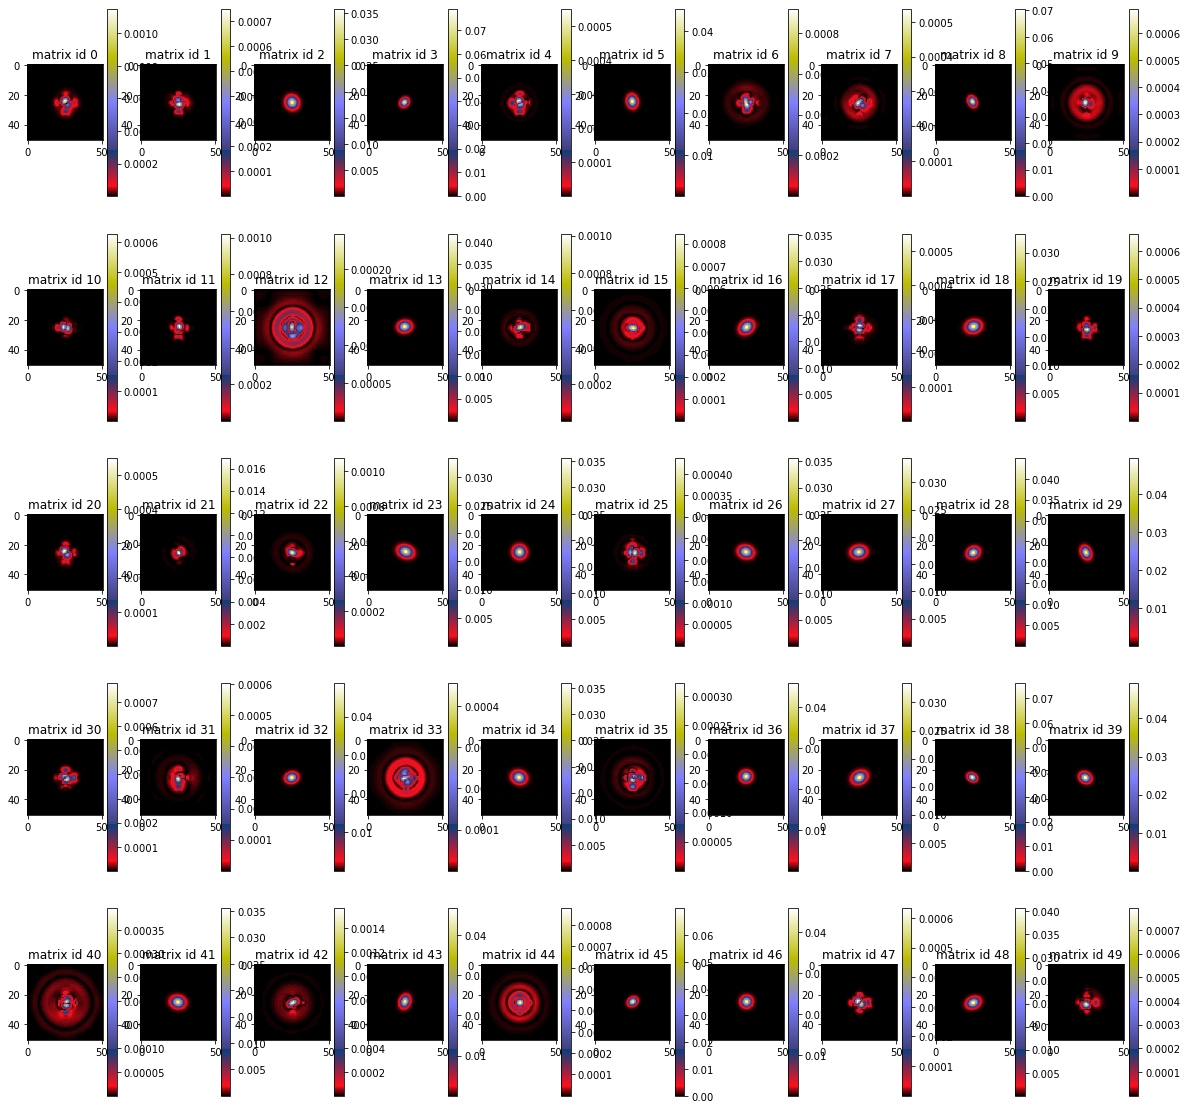

In [25]:
plot_imgs(abs(vignets_noiseless[3400:3450, :, :]))

## Saving the final dataset

In [26]:
train_dic = {'VIGNETS_NOISELESS': vignets_noiseless, 'VIGNETS_WITH_NOISE': vignets_with_noise}

In [27]:
np.save('dataset_eigenpsfs.npy', train_dic, allow_pickle=True)